# Import dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import MinMaxScaler

# Combine and explore dataset

In [2]:
def allData():
    path = '../datasets/'
    
    ori_df = pd.read_csv(f"{path}gemini_BTCUSD_2015_1min.csv")
    for item in range(2016, 2022):
        df = pd.read_csv(f"{path}/gemini_BTCUSD_{item}_1min.csv")
        new_df = pd.concat([ori_df, df], ignore_index=True)
        ori_df = new_df

    ori_df.rename({"Unix Timestamp": "Timestamp"}, axis=1, inplace=True)
    combine_df = ori_df
    combine_df.drop_duplicates(subset=["Timestamp"], keep='first', inplace=True)
    
    return combine_df

In [3]:
df = allData()

In [4]:
df

,Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1451606340,2015-12-31 23:59:00,BTCUSD,429.95,429.95,429.95,429.95,0.000000
1,1451606280,2015-12-31 23:58:00,BTCUSD,429.95,429.95,429.95,429.95,0.000000
2,1451606220,2015-12-31 23:57:00,BTCUSD,429.95,429.95,429.95,429.95,0.000000
3,1451606160,2015-12-31 23:56:00,BTCUSD,429.95,429.95,429.95,429.95,0.000000
4,1451606100,2015-12-31 23:55:00,BTCUSD,429.95,429.95,429.95,429.95,0.000000
...,...,...,...,...,...,...,...,...
3050922,1609459440000,2021-01-01 00:04:00,BTCUSD,29056.21,29056.21,29046.04,29048.46,0.032502
3050923,1609459380000,2021-01-01 00:03:00,BTCUSD,29057.27,29057.27,29028.69,29056.21,0.049909
3050924,1609459320000,2021-01-01 00:02:00,BTCUSD,29085.38,29086.14,29043.25,29057.27,5.075271
3050925,1609459260000,2021-01-01 00:01:00,BTCUSD,29033.01,29086.14,29033.01,29085.38,1.451389


In [5]:
df.set_index('Timestamp', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3050927 entries, 1451606340 to 1609459200000
Data columns (total 7 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Date    object 
 1   Symbol  object 
 2   Open    float64
 3   High    float64
 4   Low     float64
 5   Close   float64
 6   Volume  float64
dtypes: float64(5), object(2)
memory usage: 186.2+ MB


In [6]:
df.sort_index(inplace=True)

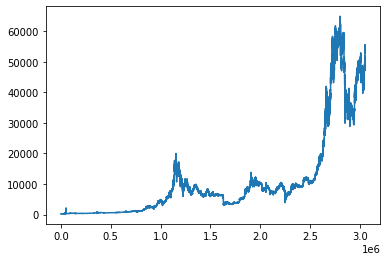

In [7]:
data_close = df['Close']
data_close = data_close.values.reshape(len(data_close), 1)
plt.plot(data_close)
plt.show()

# Scale dataset

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))

In [9]:
scaled = scaler.fit_transform(data_close)
scaled

array([[1.00535156e-04],
       [1.07495283e-04],
       [1.07495283e-04],
       ...,
       [8.28160052e-01],
       [8.27606181e-01],
       [8.28841680e-01]])

# Split dataset to training and testing

In [10]:
# split data into train and test
train_size = int(len(data_close)*0.7) # 70% of the data will be for training
test_size = len(data_close) - train_size # the rest of the data will be for testing (100-70)%

data_train, data_test = data_close[0:train_size, :], data_close[train_size:len(data_close), :]
print('Split data into train and test: ', len(data_train), len(data_test))

Split data into train and test:  2135648 915279


# Convert to Time Series, reshape to LSTM and build model

In [11]:
# need to now convert the data into time series looking back over a period of days...e.g. use last 7 days to predict price
def create_ts(ds, series):
    X, Y =[], []
    for i in range(len(ds)-series - 1):
        item = ds[i:(i+series), 0]
        X.append(item)
        Y.append(ds[i+series, 0])
    return np.array(X), np.array(Y)

series = 7

trainX, trainY = create_ts(data_train, series)
testX, testY = create_ts(data_test, series)

In [12]:
# reshape into  LSTM format - samples, steps, features
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [13]:
# build the model
model = Sequential()
model.add(LSTM(4, input_shape=(series, 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit the model
model.fit(trainX, trainY, epochs=100, batch_size=32)

Epoch 1/100
66739/66739 [==============================] - 546s 8ms/step - loss: 35595500.0000
Epoch 2/100
66739/66739 [==============================] - 495s 7ms/step - loss: 35010656.0000
Epoch 3/100
66739/66739 [==============================] - 482s 7ms/step - loss: 34434332.0000
Epoch 4/100
66739/66739 [==============================] - 474s 7ms/step - loss: 33866660.0000
Epoch 5/100
66739/66739 [==============================] - 467s 7ms/step - loss: 33308188.0000
Epoch 6/100
66739/66739 [==============================] - 471s 7ms/step - loss: 32758318.0000
Epoch 7/100
66739/66739 [==============================] - 472s 7ms/step - loss: 32217336.0000
Epoch 8/100
66739/66739 [==============================] - 469s 7ms/step - loss: 31685920.0000
Epoch 9/100
66739/66739 [==============================] - 448s 7ms/step - loss: 31162446.0000
Epoch 10/100
66739/66739 [==============================] - 437s 7ms/step - loss: 30648532.0000
Epoch 11/100
66739/66739 [=======================

In [14]:
# test this model out
trainPredictions = model.predict(trainX)
testPredictions = model.predict(testX)

# unscale predictions
trainPredictions = scaler.inverse_transform(trainPredictions)
testPredictions = scaler.inverse_transform(testPredictions)
trainY = scaler.inverse_transform([trainY])
testY = scaler.inverse_transform([testY])

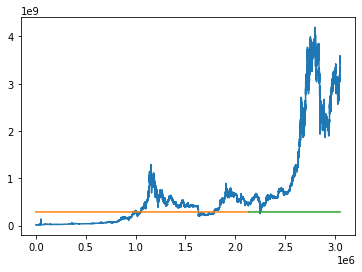

In [15]:
# lets plot the predictions on a graph and see how well it did
train_plot = np.empty_like(data_close)
train_plot[:,:] = np.nan
train_plot[series:len(trainPredictions)+series, :] = trainPredictions

test_plot = np.empty_like(data_close)
test_plot[:,:] = np.nan
test_plot[len(trainPredictions)+(series*2)+1:len(data_close)-1, :] = testPredictions

# plot on graph
plt.plot(scaler.inverse_transform(data_close))
plt.plot(train_plot)
plt.plot(test_plot)
plt.show()